# Tensorflow 实现单隐层神经网络

环境：docker image `tensorflow/tensorflow:latest-py3 (Python 3.4.3)`

由 `../ch3/simple_neural_network,ipynb` 修改而来，用于 ch4 task2

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
tf.logging.set_verbosity(tf.logging.ERROR)  # 只输出 Error 信息

### 加载 csv 文件

In [2]:
DATAFILE = '../ch3/data/data.csv'
dataset = tf.contrib.learn.datasets.base.load_csv_without_header(
    filename=DATAFILE,
    target_dtype=np.int,
    features_dtype=np.float32)

dataset.data.shape, dataset.target.shape

((200, 2), (200,))

## 1. 练习行/列向量形式的变换

主要区别包括：
* weight 矩阵的 shape 不同：行向量 `[input_dim, output_dim]`，列向量 `[output_dim, input_dim]`
* 矩阵乘法的左右顺序不同：行向量 `x * W`, 列向量 `W * x`

上次用的是行向量，这次改为列向量形式。

In [3]:
def add_nn_layer(input_, weight, bias, activation=None):
    # 假设 input_ 中每一列是一个样本
    raw_output = tf.add(tf.matmul(weight, input_), bias)
    if activation:
        return activation(raw_output)
    else:
        return raw_output

def generate_weight_and_bias(input_dim, output_dim):
    w = tf.Variable(tf.random_uniform([output_dim, input_dim]))
    bias = tf.Variable(tf.random_uniform([output_dim, 1]))
    return (w, bias)

def accuracy(preds, labels):
    return ((preds > 0.5) == labels).sum() / len(labels)

In [4]:
x = tf.placeholder(tf.float32, [2, None])
y = tf.placeholder(tf.float32, [1, None])
num_units = 8  # 隐层节点数

# 定义参数
W1, b1 = generate_weight_and_bias(2, num_units)  # 输入层->隐层
W2, b2 = generate_weight_and_bias(num_units, 1)  # 隐层->输出层

# 定义模型和损失函数
hidden = add_nn_layer(x, W1, b1, tf.tanh)
nn_raw = add_nn_layer(hidden, W2, b2)
nn = tf.sigmoid(nn_raw)
loss_nn = tf.losses.sigmoid_cross_entropy(y, nn_raw)  # 需要用激活前的输出

In [5]:
x.shape, y.shape, nn.shape

(TensorShape([Dimension(2), Dimension(None)]),
 TensorShape([Dimension(1), Dimension(None)]),
 TensorShape([Dimension(1), Dimension(None)]))

### 训练

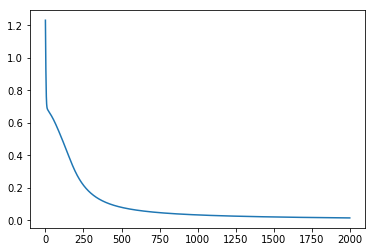

In [6]:
# 准备 feed 数据
size = dataset.target.shape[0]
inputs = dataset.data.T
labels = dataset.target.reshape(1, size)
feed = {x: inputs, y: labels}

# 训练
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train = tf.train.GradientDescentOptimizer(0.3).minimize(loss_nn)
losses_nn = []
for i in range(2000):
    sess.run(train, feed)
    losses_nn.append(sess.run(loss_nn, feed))

plt.plot(losses_nn);

### 评估准确率

In [7]:
feed_pred = {x: inputs}
preds = sess.run(nn, feed_pred)

In [8]:
inputs.shape, labels.shape, preds.shape  # 检查 shape

((2, 200), (1, 200), (1, 200))

In [9]:
accuracy(preds.reshape(size), labels.reshape(size))

1.0

## 2. 利用 tf.layers.dense 定义神经网络

为了方便调用 tf.layers.dense, 这里采用输入为行向量的形式。

### 定义模型和损失函数

借助 tf.layers.dense，可以省去自己定义 variable 和层间运算的麻烦，代码大为精简。需要注意的是它接受的 input 参数默认为行向量的形式。

In [10]:
x = tf.placeholder(tf.float32, [None, 2])
y = tf.placeholder(tf.float32, [None, 1])
num_units = 8  # 隐层节点数

hidden = tf.layers.dense(x, num_units, tf.tanh)
nn_raw = tf.layers.dense(hidden, 1)
nn = tf.sigmoid(nn_raw)
loss_nn = tf.losses.sigmoid_cross_entropy(y, nn_raw)  # 需要用激活前的输出

In [11]:
x.shape, y.shape, nn.shape

(TensorShape([Dimension(None), Dimension(2)]),
 TensorShape([Dimension(None), Dimension(1)]),
 TensorShape([Dimension(None), Dimension(1)]))

### 训练

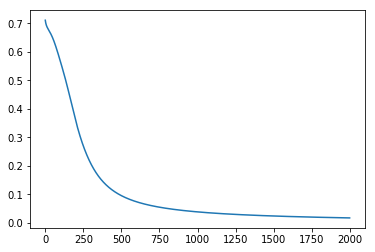

In [12]:
# 准备 feed 数据
size = dataset.target.shape[0]
inputs = dataset.data
labels = dataset.target.reshape(size, 1)
feed = {x: inputs, y: labels}

# 训练
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train = tf.train.GradientDescentOptimizer(0.3).minimize(loss_nn)
losses_nn = []
for i in range(2000):
    sess.run(train, feed)
    losses_nn.append(sess.run(loss_nn, feed))

plt.plot(losses_nn);

### 评估准确率

In [13]:
feed_pred = {x: inputs}
preds = sess.run(nn, feed_pred)

In [14]:
inputs.shape, labels.shape, preds.shape

((200, 2), (200, 1), (200, 1))

In [15]:
accuracy(preds, labels)

1.0